In [78]:
import os
from PIL import Image
import numpy
import cv2
import matplotlib.pyplot as plt
from math import atan2, cos, sin, sqrt, pi, radians, degrees

In [136]:
def getOrientation(pts, img, draw=False):
    """Get the center and angle of a contour (main axis relative to the x-axis)

    Args:
        pts (_type_): points of the contour
        img (_type_): base image
        draw (bool, optional): Draw axes and center on the image. Defaults to False.

    Returns:
        cntr (tuple): center of the contour
        angle (tuple): angle of the contour
    """

    #https://docs.opencv.org/3.4/d1/dee/tutorial_introduction_to_pca.html
    sz = len(pts)
    data_pts = numpy.empty((sz, 2), dtype=numpy.float64)
    for i in range(data_pts.shape[0]):
        data_pts[i,0] = pts[i,0,0]
        data_pts[i,1] = pts[i,0,1]
    # Perform PCA analysis
    mean = numpy.empty((0))
    mean, eigenvectors, eigenvalues = cv2.PCACompute2(data_pts, mean)
    # Store the center of the object
    cntr = (int(mean[0,0]), int(mean[0,1]))
    
    
    p1 = (cntr[0] + eigenvectors[0,0] * eigenvalues[0,0], cntr[1] + eigenvectors[0,1] * eigenvalues[0,0])
    p2 = (cntr[0] - eigenvectors[1,0] * eigenvalues[1,0], cntr[1] - eigenvectors[1,1] * eigenvalues[1,0])
    if(draw):
        cv2.circle(img, cntr, 3, (255, 0, 255), 0)
        cv2.line(img, cntr, tuple(map(round, p2)), (0, 255, 0), 1)
        cv2.line(img, cntr, tuple(map(round, p1)), (255, 0, 0), 1)
    angle = degrees(atan2(eigenvectors[0,1], eigenvectors[0,0])) # orientation in degrees
    
    return cntr, angle


def rotateImage(img, angle, point):
#https://stackoverflow.com/questions/9041681/opencv-python-rotate-image-by-x-degrees-around-specific-point
    # angle-90 do orient the shape vertically
    rot_mat = cv2.getRotationMatrix2D(point, angle-90, 1.0)
    res = cv2.warpAffine(img, rot_mat, img.shape[1::-1], flags=cv2.INTER_LINEAR)
    return res

def getContour(img):
    #expects there to be only one shape/contour
    thresh = 127
    im_bw = cv2.threshold(cv2.cvtColor(img, cv2.COLOR_BGR2GRAY), thresh, 255, cv2.THRESH_BINARY)[1]
    c, _ = cv2.findContours(im_bw, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    return c[0]

In [121]:

def calculate_ejection_fraction(mask1, mask2):
    """
    Calculate the cardiac parameters, using the systolic and diastolic mask as an input. The mask featuring the smaller volume is assumend as the "End of systole" mask.


    Args:
        mask1 (_type_): _description_
        mask2 (_type_): _description_

    Returns:
        ef (float): Ejection fraction calculated from esv and edv
    """

    v1 = calculate_volume(mask1)
    v2 = calculate_volume(mask2)

    #not absolute values
    esv = min(v1, v2)
    edv = max(v1, v2)
    ef = (edv-esv)/edv

    return ef

def calculate_volume(mask):
    """Calculates the relative volume of the ventricle, using a mask as input. 

    Args:
        mask (_type_): mask of the ventricle

    Returns:
        volume (float): volume of the ventricle
    """

    initialContour = getContour(mask)
    center, angle = getOrientation(initialContour, mask)
    rotatedMask = rotateImage(mask, angle, center)
    contour = getContour(rotatedMask)
    c = numpy.array(contour).squeeze()

    sum = 0
    for i in range(min(c[:,1]), max(c[:,1])+1):
        indices = numpy.where(c[:, 1] == i)[0]
        points = c[indices]
        x1 = min(points[:, 0])
        x2 = max(points[:, 0])
        r = abs(x2-x1) / 2
        sum += pow(r, 2)*pi

    return sum

In [137]:
#load test data
maskImg1 = Image.open("./maskTestdata/0XFEBEEFF93F6FEB9_38.png")
maskImg2 = Image.open("./maskTestdata/0XFEBEEFF93F6FEB9_25.png")
mask1 = cv2.cvtColor(numpy.array(maskImg1), cv2.COLOR_RGB2BGR)
mask2 = cv2.cvtColor(numpy.array(maskImg2), cv2.COLOR_RGB2BGR)
print(calculate_ejection_fraction(mask1, mask2))
# print(calculate_volume(mask1))


0.2912179647716839


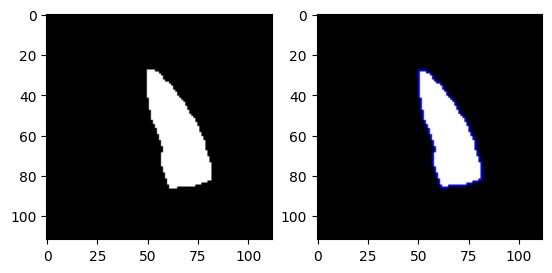

In [307]:
plt.subplot(1, 2, 1)
plt.imshow(mask1)
c, _ = cv2.findContours(cv2.cvtColor(mask1, cv2.COLOR_BGR2GRAY), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
cv2.drawContours(mask1, c, 0, (0, 0, 255), 1)
plt.subplot(1, 2, 2)
plt.imshow(mask1)
plt.show()